In [20]:
import os
import scipy.stats
import xarray as xr
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd


In [21]:
base_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought'
data_dir = f'{base_dir}/data'
reservoir_data_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/DROM_CONUS_Analysis/Data/HydroShare'
output_dir = f'{data_dir}/results/lrr_output'

os.chdir(base_dir)


In [22]:
# The analysis is by each river basin (huc4)
# Specify basin huc4 here for following analysis
huc4 = '1709'

In [23]:
# ---- Prepare geospatial files ---- #

nhd_data_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/Drought_Cycle_Analysis/Data'
crs = 'EPSG:4326'
huc2_conus = [f'0{i}' if i<10 else f'{i}' for i in range(1, 19)]

# read reservoirs
df = pd.read_excel(f'{data_dir}/processed/reservoirs.xlsx', dtype={'huc4':str})
gdf_reservoirs = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
gdf_reservoirs.set_crs(crs, inplace=True, allow_override=True)

# read HUCs
huc2 = huc4[0:2]
gdb_file = f'{nhd_data_dir}/Raw/WBD/WBD_{huc2}_HU2_GDB.gdb'
gdf_huc2_all = gpd.read_file(gdb_file, layer='WBDHU2')
gdf_huc4_all = gpd.read_file(gdb_file, layer='WBDHU4')
gdf_huc6_all = gpd.read_file(gdb_file, layer='WBDHU6')
gdf_huc8_all = gpd.read_file(gdb_file, layer='WBDHU8')
gdf_huc10_all = gpd.read_file(gdb_file, layer='WBDHU10')

# set crs
gdf_huc2_all = gdf_huc2_all.set_crs(crs, inplace=False, allow_override=True)    # includes the huc2 region
gdf_huc4_all = gdf_huc4_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc4 subregions in this huc2 region
gdf_huc6_all = gdf_huc6_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc6 basins in this huc2 region
gdf_huc8_all = gdf_huc8_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc8 subbasins in this huc2 region
gdf_huc10_all = gdf_huc10_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc10 subbasins in this huc2 region

########## Prepare flow lines ##########

if huc2 == '03':    # multiple NHDP files for 03
    flow_attr_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDPlusAttributes' for i in ['N','S','W']]
    hydro_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDSnapshot/Hydrography' for i in ['N','S','W']]
elif huc2 == '10': 
    flow_attr_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDPlusAttributes' for i in ['U','L']]
    hydro_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDSnapshot/Hydrography' for i in ['U','L']]
else:
    flow_attr_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}/NHDPlusAttributes']
    hydro_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}/NHDSnapshot/Hydrography']

gdf_flow_list = []
for flow_attr_file, hydro_file in zip(flow_attr_file_list, hydro_file_list):
    gdf_fline_vaa = gpd.read_file(flow_attr_file, layer='PlusFlowlineVAA')
    gdf_fline = gpd.read_file(hydro_file, layer='NHDFlowline')

    # change COMID to ComID if the error exists
    if not 'ComID' in gdf_fline:
        gdf_fline.rename(columns={'COMID':'ComID'}, inplace=True)

    # change vaa file ComID to int
    to_int_var = ['ComID', 'StreamOrde', 'StreamCalc']
    gdf_fline_vaa[to_int_var] = gdf_fline_vaa[to_int_var].astype(int)

    # merge this two gdfs
    to_merge_vars = ['ComID', 'StreamOrde', 'StreamCalc', 'FromNode', 'ToNode']
    gdf_flow = gdf_fline.merge(gdf_fline_vaa[to_merge_vars], how='inner', on='ComID')
    
    gdf_flow_list.append(gdf_flow)

gdf_flow = pd.concat(gdf_flow_list)

# set crs
gdf_flow = gdf_flow.set_crs(crs, inplace=True, allow_override=True)

# subset to the target huc4
gdf_flow_huc4 = gdf_flow.sjoin(gdf_huc4_all.loc[gdf_huc4_all['huc4']==huc4], how='inner', predicate='intersects')

########## End Prepare flow lines ##########


# Sustainability Index

In [24]:
# ---- Define reliability, resilience, vulnerability ---- #

def cal_reliability(deficit_array, threshold=0.0001):
    """
    Calculate reliability of water deficit time series for a given grid.
    
    threshold: the threshold of water deficit, above which to be considered as a deficit
    """

    n_deficit = deficit_array[deficit_array > threshold].size

    reliability = 1 - n_deficit / deficit_array.size

    return(reliability)

def cal_resilience(deficit_array, threshold=0.0001):
    """
    Calculate resilience of water deficit time series for a given grid.
        Resilience: number of times a non-deficit day follows a deficit day / number of deficit days
    
    threshold: the threshold of water deficit, above which to be considered as a deficit
    """

    n_deficit = deficit_array[deficit_array > threshold].size
    if n_deficit == 0:    # if there is no deficit, no resilience
        return np.nan
    
    n_resilience = 0

    for i in range(deficit_array.size - 1):
        if deficit_array[i] > threshold and deficit_array[i + 1] <= threshold:
            n_resilience += 1

    resilience = n_resilience / n_deficit
    
    return(resilience)

def cal_vulnerability(deficit_array, threshold=0.0001):
    """
    Calculate vulnerability of water deficit time series for a given grid.
        Vulnerability: sum of deficit amount / number of deficit days
    
    threshold: the threshold of water deficit, above which to be considered as a deficit
    """

    n_deficit = deficit_array[deficit_array > threshold].size
    if n_deficit == 0:    # if there is no deficit, no vulnerability
        return np.nan

    vulnuerability = np.sum(deficit_array[deficit_array > threshold]) / n_deficit

    return(vulnuerability)



In [26]:
# ---- Calculate sustainability index & add to dataset ---- #

# read simulation results
ds = xr.load_dataset(f'{output_dir}/{huc4}/model_states_{huc4}.nc')

# Omit the first 2 years of spinup
spinup_start = '1988-01-01'
spinup_end = '1990-01-01'
spinup_len = (pd.to_datetime(spinup_end) - pd.to_datetime(spinup_start)).days
# skip the first 2 years of spinup
ds = ds.isel(time=slice(spinup_len, None))

# get the grid indices that locate in the huc4: flow_direction != -1
huc4_lat_lon_tup = np.where(ds['flow_direction'] != -1)    # (lat_ind_array, lon_ind_array) pair

# loop through each grid cell & calculate sustainability index & add to the ds
reliability_array = np.ones_like(ds['water_deficit'].isel(time=0).values) * np.nan
resilience_array = np.ones_like(ds['water_deficit'].isel(time=0).values) * np.nan
vulnerability_array = np.ones_like(ds['water_deficit'].isel(time=0).values) * np.nan
for lat_ind, lon_ind in zip(huc4_lat_lon_tup[0], huc4_lat_lon_tup[1]):
    # get the water deficit time series
    deficit_array = ds['water_deficit'].isel(lat=lat_ind, lon=lon_ind).values
    
    # calculate sustainability index
    reliability = cal_reliability(deficit_array)
    resilience = cal_resilience(deficit_array)
    vulnerability = cal_vulnerability(deficit_array)

    # add to the array
    reliability_array[lat_ind, lon_ind] = reliability
    resilience_array[lat_ind, lon_ind] = resilience
    vulnerability_array[lat_ind, lon_ind] = vulnerability

# add to the ds
ds['reliability'] = (('lat', 'lon'), reliability_array)
ds['resilience'] = (('lat', 'lon'), resilience_array)
ds['vulnerability'] = (('lat', 'lon'), vulnerability_array)



## Visualize Sustainability Index

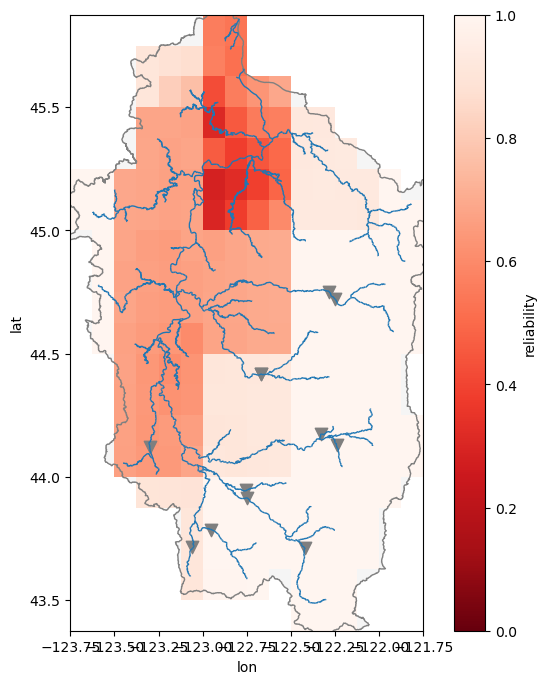

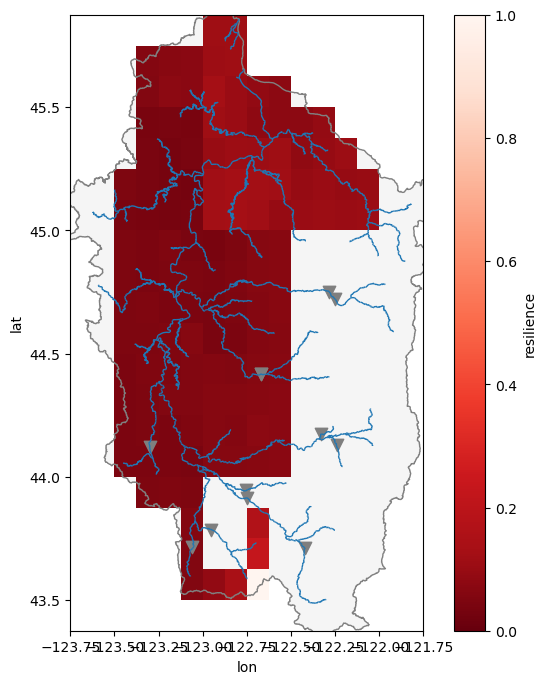

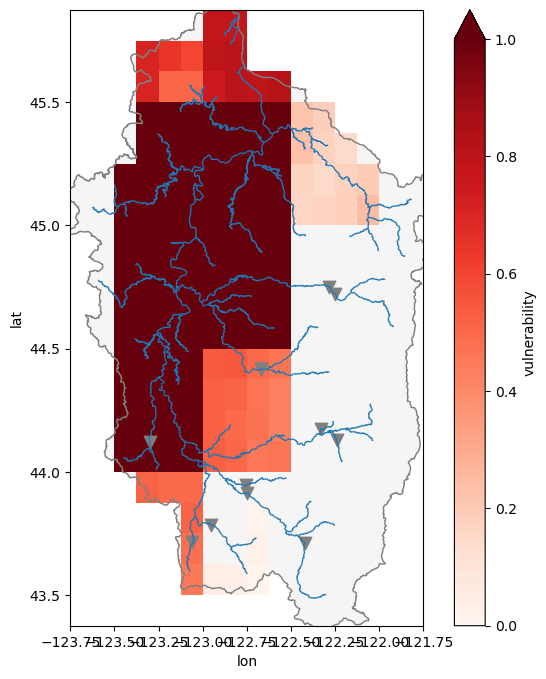

In [27]:
# ---- Plot reliability, resilience, & vulnerability ---- #

plot_dict = {'reliability': 'Reds_r', 'resilience': 'Reds_r', 'vulnerability': 'Reds'}

for sus_ind, cmap in plot_dict.items():

    fig, ax = plt.subplots(figsize=(8, 8))

    # plot huc4 basin as background
    gdf_huc4_all.loc[gdf_huc4_all['huc4']==huc4].plot(ax=ax, facecolor='whitesmoke', edgecolor='none')

    # plot flow lines
    max_order = gdf_flow_huc4['StreamOrde'].max()
    min_order_to_keep = 4
    gdf_flow_huc4.loc[gdf_flow_huc4['StreamOrde']>=min_order_to_keep].plot(ax=ax, linewidth=1, color='tab:blue')

    # plot sustainability index
    ds[sus_ind].plot(ax=ax, cmap=cmap, vmin=0, vmax=1, alpha=1)

    # plot huc4 basin
    gdf_huc4_all.loc[gdf_huc4_all['huc4']==huc4].plot(ax=ax, facecolor='none', edgecolor='gray')

    # plot reservoirs
    gdf_reservoirs.loc[gdf_reservoirs['huc4']==huc4].plot(ax=ax, color='tab:gray', marker='v', markersize=80)

    plt.savefig(f'{output_dir}/{huc4}/sustainability_index_{sus_ind}.png', dpi=300, bbox_inches='tight')

    plt.show()

# Streamflow (Up vs. Downstream) Analysis

In [28]:
# read simulation results
ds = xr.load_dataset(f'{output_dir}/{huc4}/model_states_{huc4}.nc')

# Omit the first 2 years of spinup
spinup_start = '1988-01-01'
spinup_end = '1990-01-01'
spinup_len = (pd.to_datetime(spinup_end) - pd.to_datetime(spinup_start)).days
# skip the first 2 years of spinup
ds = ds.isel(time=slice(spinup_len, None))

In [29]:
def cal_ssi_threshold(streamflow_series, quantile=0.25):
    """
    Calculate streamflow drought index based on the threshold method.

    streamflow_series: monthly streamflow Series, with datetime index
    """

    streamflow_monthly_mean = streamflow_series.groupby(streamflow_series.index.month).transform(lambda x: x.mean())
    streamflow_monthly_threshold = streamflow_series.groupby(streamflow_series.index.month).transform(lambda x: x.quantile(quantile))
    ssi = (streamflow_series - streamflow_monthly_threshold) / streamflow_monthly_mean

    return(ssi)

def cal_ssi_standardized(streamflow_series, mth_accum=3):
    """
    Calculate streamflow drought index based on the standardized method.
        Fit a Gamma distribution to the monthly streamflow data, and transform to z score.

    streamflow_series: monthly streamflow Series, with datetime index
    mon_acc: number of months to accumulate
    """

    # accumulate streamflow
    streamflow_series = streamflow_series.rolling(mth_accum).sum()

    # fit a Gamma distribution to the monthly streamflow data
    alpha, loc, beta = scipy.stats.gamma.fit(streamflow_series.dropna())

    # convert to SPI using normal distribution
    cdf_gamma = scipy.stats.gamma.cdf(streamflow_series, a=alpha, loc=loc, scale=beta)
    ssi = scipy.stats.norm.ppf(cdf_gamma)

    return(ssi)

def identify_drought_events(drought_index_series, threshold=0):
    """
    Identify all drought events based on the drought index time series.
        Drought event: consecutive months with drought index below the threshold

    drought_index_series: monthly drought index Series, with datetime index
    threshold: the threshold of drought index, below which to be considered as a drought

    Return:
        drought_event_list: list of drought events, each element is a tuple of (start_date, end_date)
    """

    drought_index_series = drought_index_series.dropna()    # drop NaN values coming from monthly accumulation

    # Identifying points where the index is below the threshold
    is_drought = drought_index_series < threshold

    # Identifying the start of drought events
    drought_start = is_drought & (~is_drought.shift(1, fill_value=False))

    # Identifying the end of drought events
    drought_end = is_drought & (~is_drought.shift(-1, fill_value=False))

    # Extracting start and end dates of droughts
    start_dates = drought_index_series.index[drought_start]
    end_dates = drought_index_series.index[drought_end]

    # Creating a list of tuples for each drought event
    drought_events = list(zip(start_dates, end_dates))

    # Check if it has been a drought at the begining, remove the first event if
    if is_drought[0] == True:
        drought_events.pop(0)
    
    # Check if the last drought event is still ongoing, remove the last event if
    if is_drought[-1] == True:
        drought_events.pop(-1)

    return drought_events

def cal_drought_duration(drought_event_list):
    """
    Return: list of drought duration for each drought event
    """
    
    drought_duration_list = [(end_date - start_date).days // 30 for start_date, end_date in drought_event_list]
    # it can come with 0, because I divide by 30, but Feb. has only 28 days
    # change 0 to 1
    drought_duration_list = [1 if i==0 else i for i in drought_duration_list]

    return(drought_duration_list)

def cal_drought_severity(drought_index_series, drought_event_list):
    """
    Return: list of drought severity for each drought event
    """

    drought_severity_list = []
    for start_date, end_date in drought_event_list:
        drought_severity = drought_index_series.loc[start_date:end_date].sum()
        drought_severity_list.append(-drought_severity)

    return(drought_severity_list)

def cal_drought_intensity(drought_index_series, drought_event_list):
    """
    Return: list of drought intensity for each drought event
    """

    drought_intensity_list = []
    for start_date, end_date in drought_event_list:
        drought_severity = drought_index_series.loc[start_date:end_date].sum()
        drought_duration = (end_date - start_date).days // 30
        drought_duration = drought_duration if drought_duration > 0 else 1
        drought_intensity = drought_severity / drought_duration
        drought_intensity_list.append(-drought_intensity)

    return(drought_intensity_list)

def cal_cdf(data_list):
    data_sorted = np.sort(data_list)
    cdf = np.arange(1, data_sorted.size + 1) / data_sorted.size
    return(data_sorted, cdf)



99


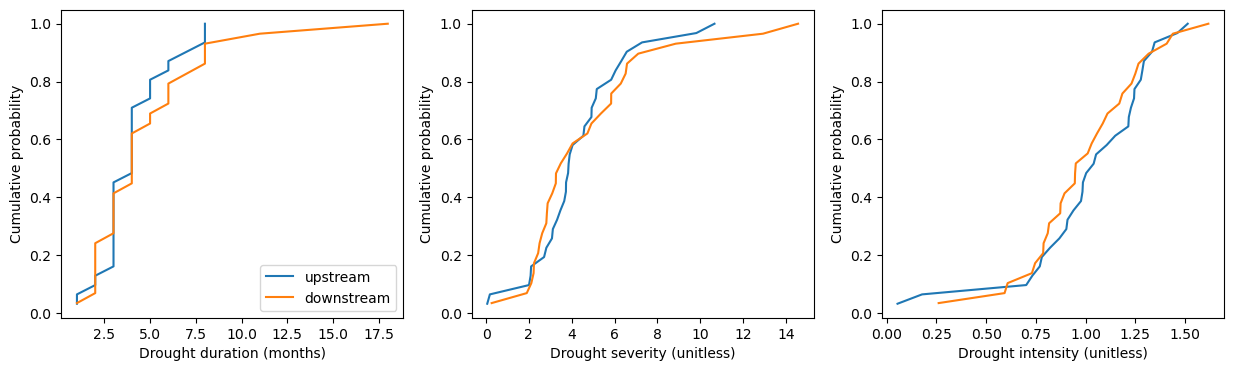

100


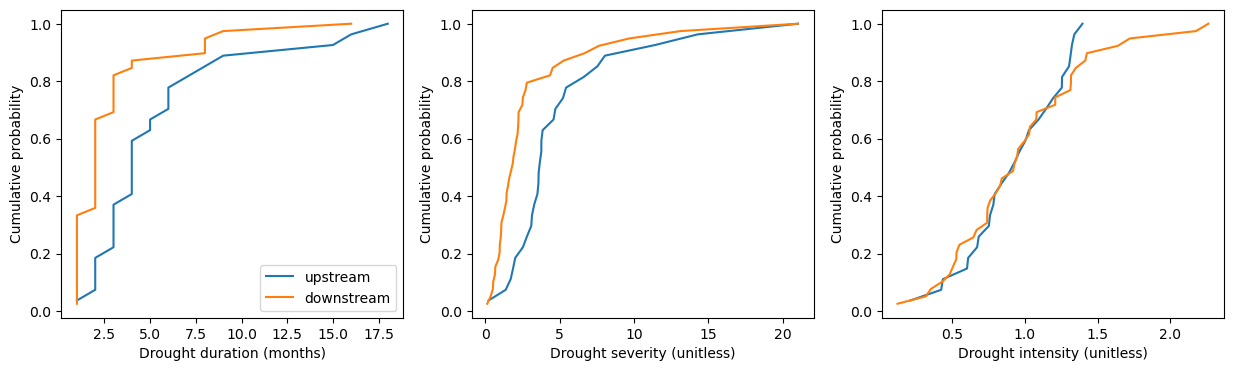

97


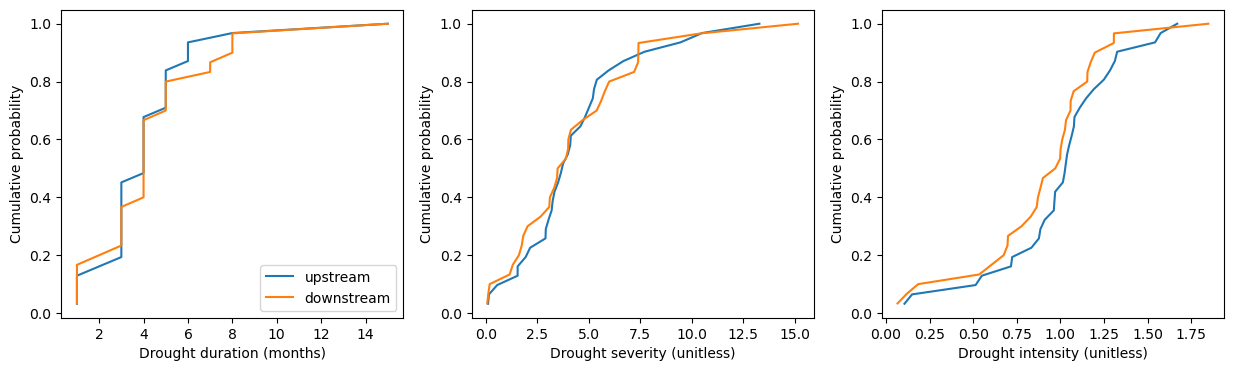

92


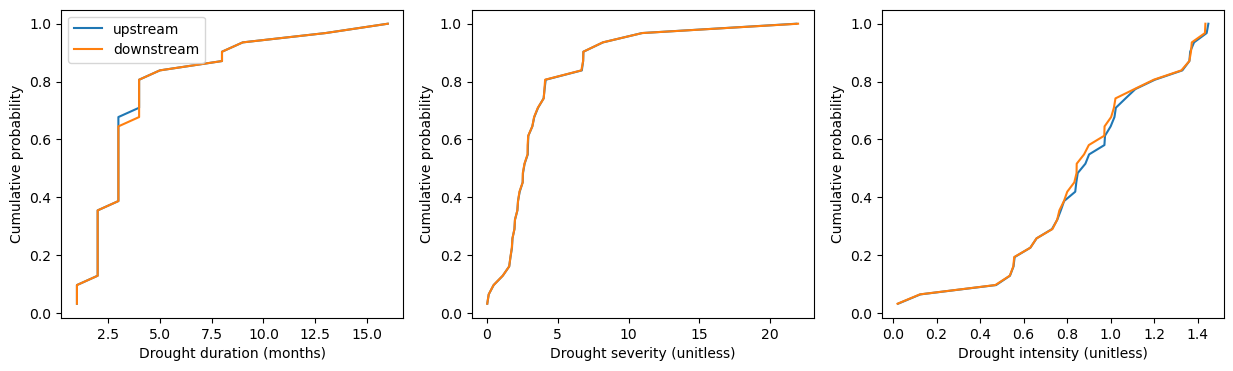

90


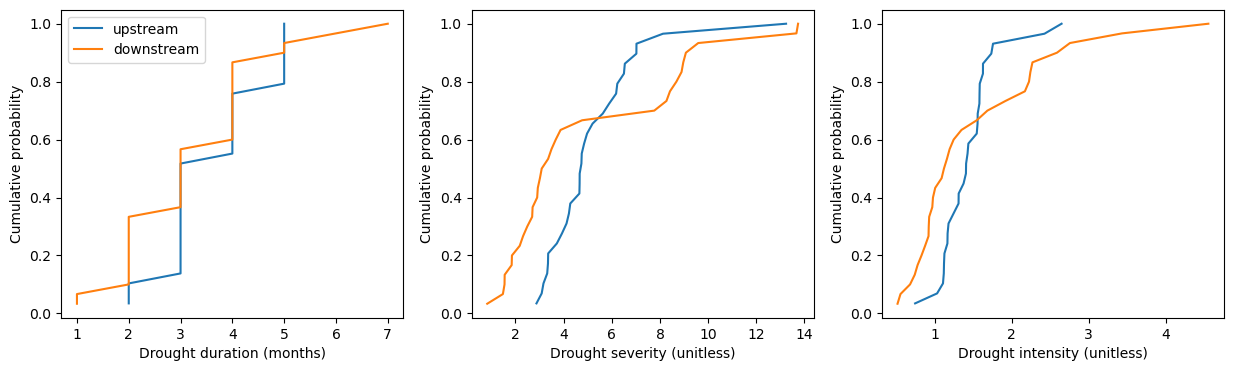

88


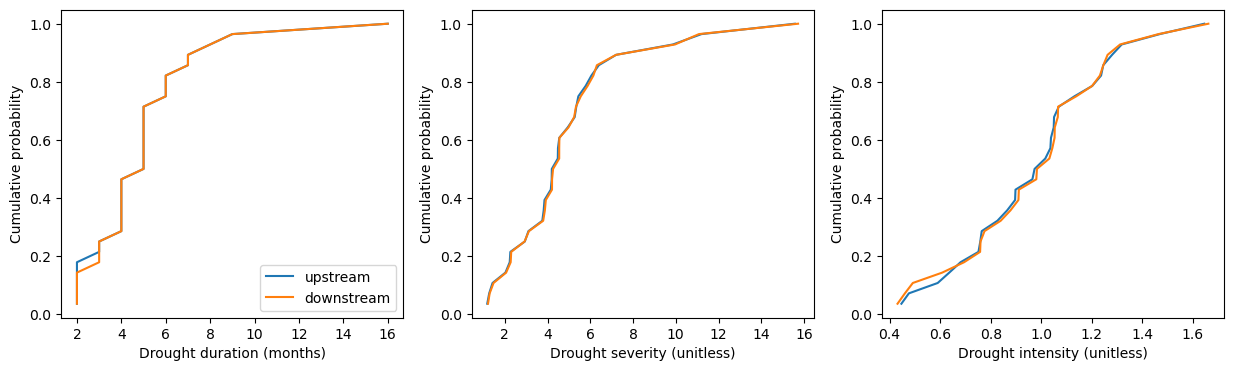

89


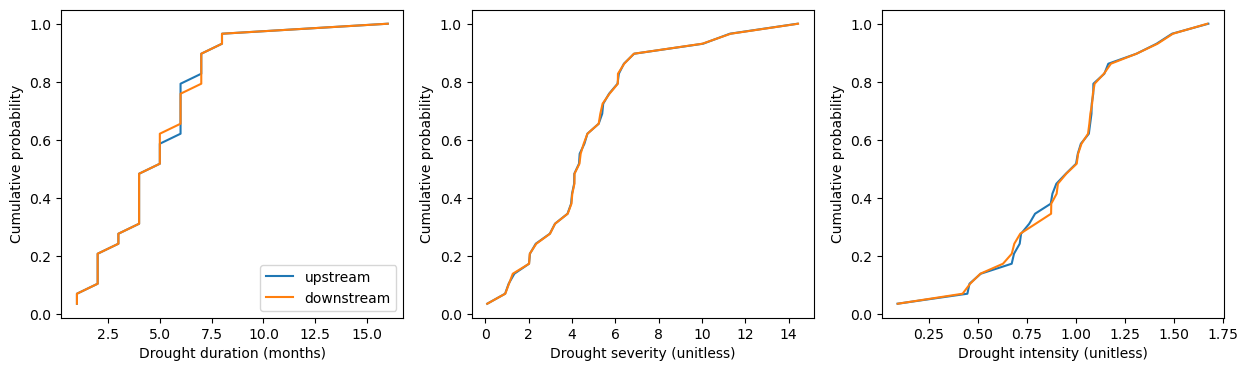

85


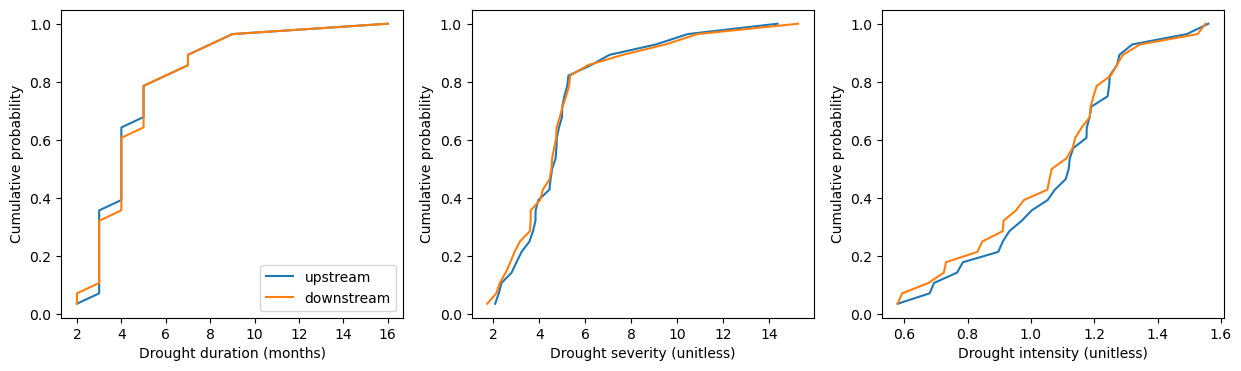

80


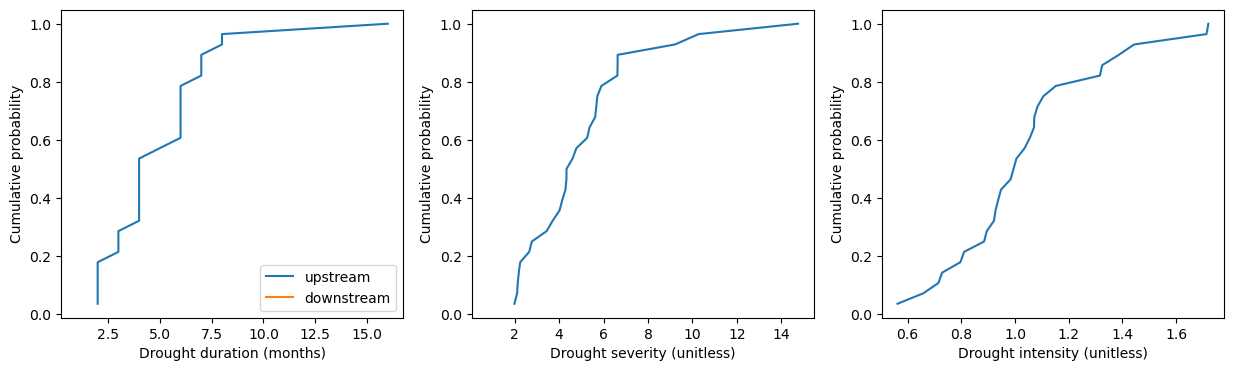

10029


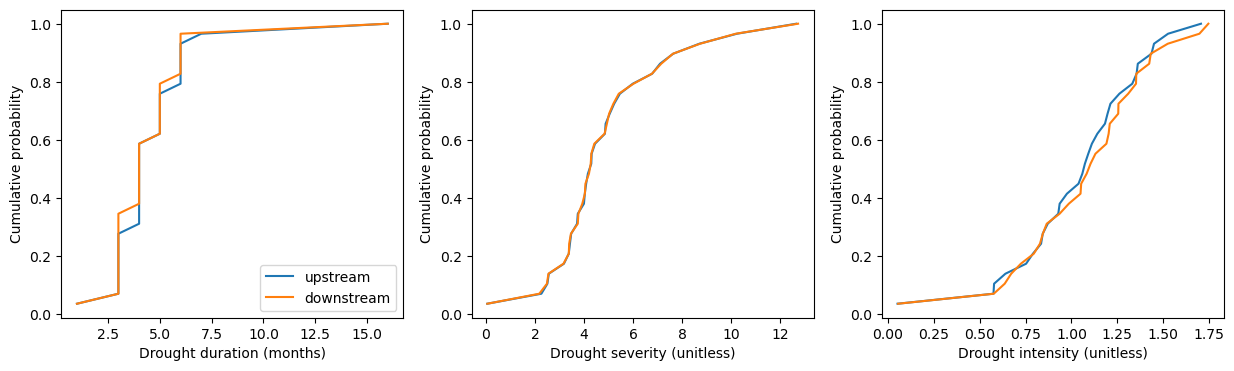

In [30]:
# get the grid indices that locate in the huc4: flow_direction != -1
# & the grid indices that have reservoirs: reservoir_id > 0
res_grid_lat_lon_tup = np.where((ds['flow_direction'] != -1) & (ds['reservoir_id'] > 0))    # (lat_ind_array, lon_ind_array) pair

# loop through each reservoir cell & do the analysis
for lat_ind, lon_ind in zip(res_grid_lat_lon_tup[0], res_grid_lat_lon_tup[1]):
    res_gid = ds['reservoir_id'].isel(lat=lat_ind, lon=lon_ind).values
    print(res_gid)

    # get streamflow time series
    df_streamflow = ds[['outflow_before_operation', 'outflow_after_operation']].isel(lat=lat_ind, lon=lon_ind).drop_vars(['lat', 'lon']).to_dataframe()
    # convert object index to datetime index
    df_streamflow.index = pd.to_datetime(df_streamflow.index)

    # Calculate streamflow drought index for up- & downstream
    # 1. convert to monthly
    df_streamflow_monthly = df_streamflow.resample('MS').sum()

    # 2. calculate ssi
    df_streamflow_monthly['outflow_before_operation_ssi_threshold'] = cal_ssi_threshold(df_streamflow_monthly['outflow_before_operation'])
    df_streamflow_monthly['outflow_after_operation_ssi_threshold'] = cal_ssi_threshold(df_streamflow_monthly['outflow_after_operation'])
    
    mth_accum = 3
    df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'] = cal_ssi_standardized(df_streamflow_monthly['outflow_before_operation'], mth_accum)
    df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'] = cal_ssi_standardized(df_streamflow_monthly['outflow_after_operation'], mth_accum)

    # Analyze drought events
    drought_list_upstream = identify_drought_events(df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'], threshold=0)
    drought_list_downstream = identify_drought_events(df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'], threshold=0)

    # drought numbers
    n_drought_upstream = len(drought_list_upstream)
    n_drought_downstream = len(drought_list_downstream)

    # drought duration
    drought_duration_upstream_list = cal_drought_duration(drought_list_upstream)
    drought_duration_downstream_list = cal_drought_duration(drought_list_downstream)

    # drought severity
    drought_severity_upstream_list = cal_drought_severity(df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'], drought_list_upstream)
    drought_severity_downstream_list = cal_drought_severity(df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'], drought_list_downstream)

    # drought intensity
    drought_intensity_upstream_list = cal_drought_intensity(df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'], drought_list_upstream)
    drought_intensity_downstream_list = cal_drought_intensity(df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'], drought_list_downstream)

    # Plot cdf
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    # duration
    data_sorted, cdf = cal_cdf(drought_duration_upstream_list)
    ax[0].plot(data_sorted, cdf, label='upstream')
    data_sorted, cdf = cal_cdf(drought_duration_downstream_list)
    ax[0].plot(data_sorted, cdf, label='downstream')
    ax[0].set_xlabel('Drought duration (months)')
    ax[0].set_ylabel('Cumulative probability')

    # severity
    data_sorted, cdf = cal_cdf(drought_severity_upstream_list)
    ax[1].plot(data_sorted, cdf, label='upstream')
    data_sorted, cdf = cal_cdf(drought_severity_downstream_list)
    ax[1].plot(data_sorted, cdf, label='downstream')
    ax[1].set_xlabel('Drought severity (unitless)')
    ax[1].set_ylabel('Cumulative probability')

    # intensity
    data_sorted, cdf = cal_cdf(drought_intensity_upstream_list)
    ax[2].plot(data_sorted, cdf, label='upstream')
    data_sorted, cdf = cal_cdf(drought_intensity_downstream_list)
    ax[2].plot(data_sorted, cdf, label='downstream')
    ax[2].set_xlabel('Drought intensity (unitless)')
    ax[2].set_ylabel('Cumulative probability')

    ax[0].legend()

    plt.savefig(f'{output_dir}/{huc4}/drought_cdf_{res_gid}.png', dpi=300, bbox_inches='tight')
    plt.show()


    # # Plot histogram
    # fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    # ax[0].hist(drought_duration_upstream_list, bins=15, alpha=0.8, label='upstream')
    # ax[0].hist(drought_duration_downstream_list, bins=15, alpha=0.8, label='downstream')
    # ax[0].set_xlabel('Drought duration (months)')
    # ax[0].set_ylabel('Frequency')

    # ax[1].hist(drought_severity_upstream_list, bins=15, alpha=0.8, label='upstream')
    # ax[1].hist(drought_severity_downstream_list, bins=15, alpha=0.8, label='downstream')
    # ax[1].set_xlabel('Drought severity (unitless)')
    # ax[1].set_ylabel('Frequency')

    # ax[2].hist(drought_intensity_upstream_list, bins=15, alpha=0.8, label='upstream')
    # ax[2].hist(drought_intensity_downstream_list, bins=15, alpha=0.8, label='downstream')
    # ax[2].set_xlabel('Drought intensity (unitless)')
    # ax[2].set_ylabel('Frequency')

    # ax[0].legend()

    # plt.show()
    

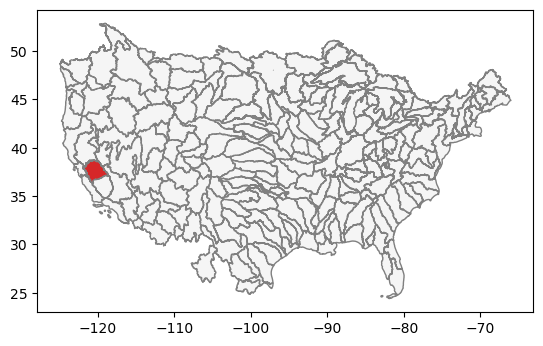

In [39]:
fig, ax = plt.subplots()

huc4_highlight = '1804'

# plot huc4 across CONUS
for huc2 in huc2_conus:
    # read HUC2s
    gdb_file = f'{nhd_data_dir}/Raw/WBD/WBD_{huc2}_HU2_GDB.gdb'
    gdf_huc4_all = gpd.read_file(gdb_file, layer='WBDHU4')

    # set crs
    gdf_huc4_all = gdf_huc4_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc4 subregions in this huc2 region

    # plot huc4
    gdf_huc4_all.plot(ax=ax, facecolor='whitesmoke', edgecolor='gray')

    # plot huc4 of interest
    if huc2 == huc4_highlight[0:2]:
        gdf_huc4_all.loc[gdf_huc4_all['huc4']==huc4_highlight].plot(ax=ax, facecolor='tab:red', edgecolor='gray')


plt.show()